In [4]:
import pandas as pd
file_name = 'data/import_volume_data.csv'

In [5]:
russia_flat_data = pd.read_csv(file_name, delimiter=';')

In [ ]:
russia_data_all_years = russia_flat_data[russia_flat_data['3_variable_attribute_label'].str.contains('Russia', case=False, na=False)]
russia_export_value_all = russia_data_all_years[russia_data_all_years['value_variable_label'].str.contains('Exports: Value', case=False, na=False)]
russia_export_mass_all = russia_data_all_years[russia_data_all_years['value_variable_label'].str.contains('Exports: Net mass', case=False, na=False)]

# Convert the 'time' column to a numeric type for plotting
russia_export_value_all['time'] = pd.to_numeric(russia_export_value_all['time'], errors='coerce')
russia_export_mass_all['time'] = pd.to_numeric(russia_export_mass_all['time'], errors='coerce')

# Sort the data by time
russia_export_value_all = russia_export_value_all.sort_values(by='time')
russia_export_mass_all = russia_export_mass_all.sort_values(by='time')


/tmp/ipykernel_16865/2015302620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  russia_export_value_all['time'] = pd.to_numeric(russia_export_value_all['time'], errors='coerce')
/tmp/ipykernel_16865/2015302620.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  russia_export_mass_all['time'] = pd.to_numeric(russia_export_mass_all['time'], errors='coerce')


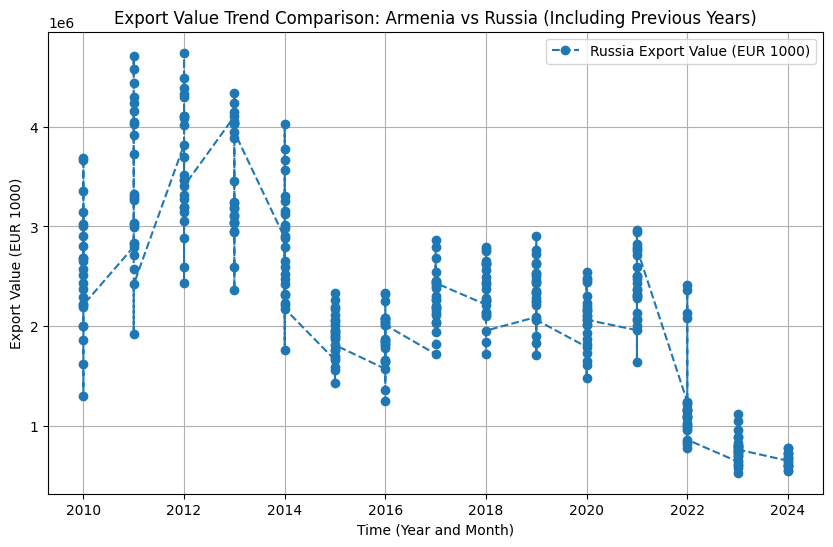

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(russia_export_value_all['time'], russia_export_value_all['value'], label='Russia Export Value (EUR 1000)', marker='o', linestyle='--')
plt.xlabel('Time (Year and Month)')
plt.ylabel('Export Value (EUR 1000)')
plt.title('Export Value Trend Comparison: Armenia vs Russia (Including Previous Years)')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_67483/453510892.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['datetime'] = pd.to_datetime(
/home/maria/projects/europe-russia-trade-and-sanctions/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/maria/projects/europe-russia-trade-and-sanctions/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Top 10 Statistical Test Results (t-test):
                                      t-statistic       p-value
Lithuania (since 1992)                 -25.255054  8.736031e-45
Poland                                 -23.186173  4.195929e-43
Russian Federation (since 05/1992)      21.500334  1.985952e-42
Bulgaria                               -21.580217  4.662548e-33
Latvia (since 1992)                    -20.734185  1.059566e-32
Romania                                -17.738101  1.186348e-31
Croatia (since 05/1992)                -21.563774  7.922917e-30
Serbia (since 06/2005)                 -19.481747  2.870236e-29
Netherlands                            -18.125249  2.481527e-28
United States                          -18.517231  2.296984e-27
Hungary                                -15.070790  2.503810e-25
Iran, Islamic Republic of               12.448356  1.112478e-24
Belgium (since 1999)                   -13.787549  1.952395e-23
Melilla (since 1999)                    11.741063  2.733498e-2

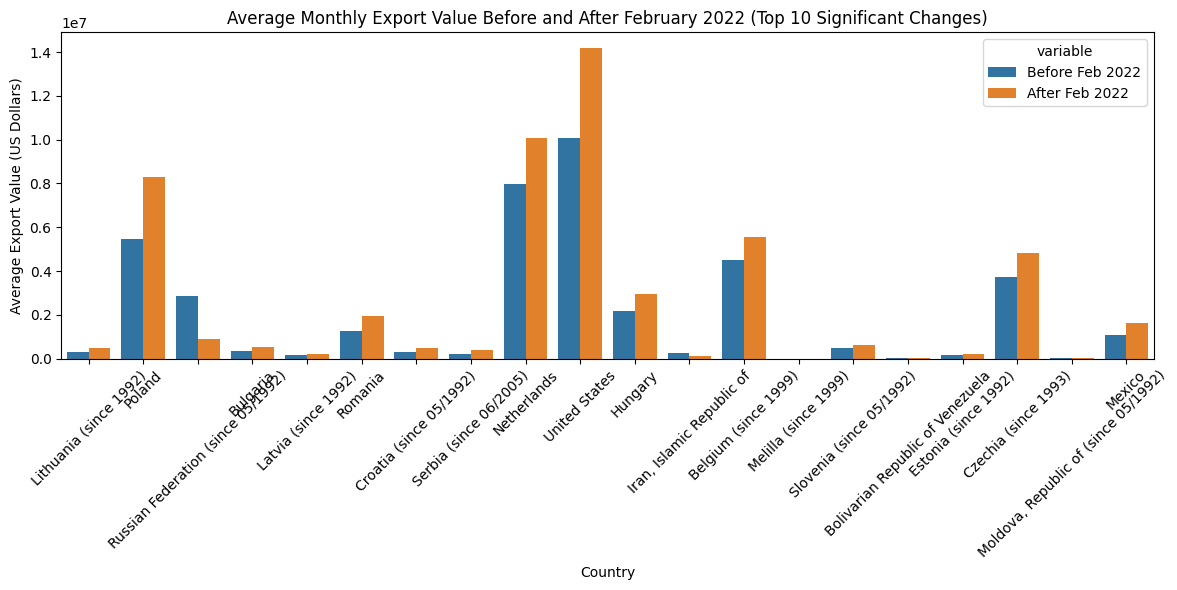

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file to examine its structure
file_path = 'data/import_volume_data.csv'
data = pd.read_csv(file_path, delimiter=';')

# Filter for export value in US Dollars
data_filtered = data[data['value_variable_label'].str.contains('Exports: Value \(US-Dollar\)', case=False, na=False)]

# Create a datetime column from year and month
data_filtered['datetime'] = pd.to_datetime(
    data_filtered['time'].astype(str) + ' ' + data_filtered['1_variable_attribute_label'],
    format='%Y %B',
    errors='coerce'
)

# Drop rows with NaT in 'datetime' after conversion to avoid issues
data_filtered = data_filtered.dropna(subset=['datetime'])

# Convert value to numeric
data_filtered['value'] = pd.to_numeric(data_filtered['value'], errors='coerce')

# Split the data into before and after February 2022
before_feb_2022 = data_filtered[data_filtered['datetime'] < '2022-02-01']
after_feb_2022 = data_filtered[data_filtered['datetime'] >= '2022-02-01']

# Group data by country and calculate average monthly exports
before_avg = before_feb_2022.groupby('3_variable_attribute_label')['value'].mean()
after_avg = after_feb_2022.groupby('3_variable_attribute_label')['value'].mean()

# Merge the before and after data for comparison
comparison_df = pd.DataFrame({'Before Feb 2022': before_avg, 'After Feb 2022': after_avg})
comparison_df = comparison_df.dropna()

# Perform a t-test to check for statistically significant changes
results = {}
for country in comparison_df.index:
    before_values = before_feb_2022[before_feb_2022['3_variable_attribute_label'] == country]['value']
    after_values = after_feb_2022[after_feb_2022['3_variable_attribute_label'] == country]['value']
    t_stat, p_value = ttest_ind(before_values, after_values, equal_var=False, nan_policy='omit')
    results[country] = {'t-statistic': t_stat, 'p-value': p_value}

# Display the results
results_df = pd.DataFrame(results).T

# Sort by the most significant changes (lowest p-values)
results_df_sorted = results_df.sort_values(by='p-value').head(20)
print("Top 10 Statistical Test Results (t-test):")
print(results_df_sorted)

# Plot the comparison for the top 10 significant changes
significant_countries = results_df_sorted.index
comparison_top10_df = comparison_df.loc[significant_countries]

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_top10_df.reset_index().melt(id_vars='index', 
                                                       value_vars=['Before Feb 2022', 'After Feb 2022']), 
            x='index', y='value', hue='variable')
plt.title('Average Monthly Export Value Before and After February 2022 (Top 10 Significant Changes)')
plt.xlabel('Country')
plt.ylabel('Average Export Value (US Dollars)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_67483/953208715.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['datetime'] = pd.to_datetime(
/home/maria/projects/europe-russia-trade-and-sanctions/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/maria/projects/europe-russia-trade-and-sanctions/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Top 30 Statistical Test Results (t-test):
                                      t-statistic       p-value
Russian Federation (since 05/1992)      25.936379  5.984866e-61
Lithuania (since 1992)                 -24.391947  1.570572e-42
Poland                                 -22.395790  6.223152e-41
Bulgaria                               -21.789955  3.917127e-33
Latvia (since 1992)                    -20.088965  5.446683e-31
Romania                                -17.366036  3.742138e-30
Croatia (since 05/1992)                -21.088397  1.080262e-28
Serbia (since 06/2005)                 -19.067777  5.111226e-28
United States                          -18.987605  6.929509e-28
Netherlands                            -17.474121  8.858236e-27
Iran, Islamic Republic of               12.635195  4.435260e-25
Hungary                                -14.674385  5.892743e-24
Melilla (since 1999)                    11.683151  5.965804e-23
Belgium (since 1999)                   -13.372364  4.188754e-2

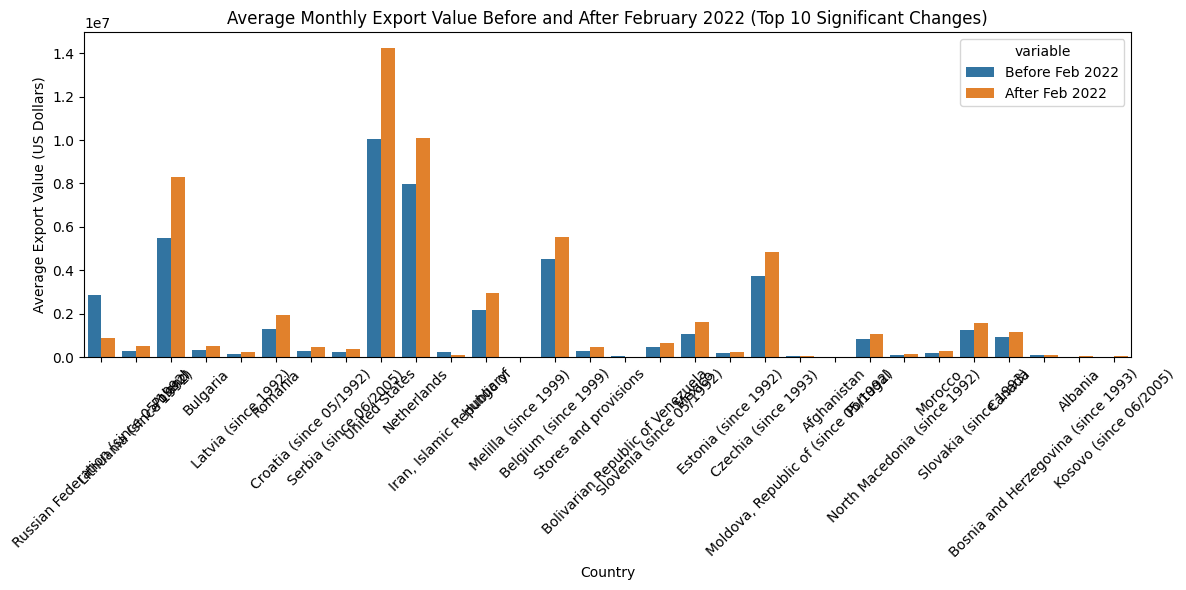

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file to examine its structure
file_path = 'data/import_volume_data.csv'
data = pd.read_csv(file_path, delimiter=';')

# Filter for export value in US Dollars
data_filtered = data[data['value_variable_label'].str.contains('Dollar', case=False, na=False)]

# Create a datetime column from year and month
data_filtered['datetime'] = pd.to_datetime(
    data_filtered['time'].astype(str) + ' ' + data_filtered['1_variable_attribute_label'],
    format='%Y %B',
    errors='coerce'
)

# Drop rows with NaT in 'datetime' after conversion to avoid issues
data_filtered = data_filtered.dropna(subset=['datetime'])

# Convert value to numeric
data_filtered['value'] = pd.to_numeric(data_filtered['value'], errors='coerce')

# Split the data into before and after February 2022
before_feb_2022 = data_filtered[data_filtered['datetime'] < '2022-03-01']
after_feb_2022 = data_filtered[data_filtered['datetime'] >= '2022-03-01']

# Group data by country and calculate average monthly exports
before_avg = before_feb_2022.groupby('3_variable_attribute_label')['value'].mean()
after_avg = after_feb_2022.groupby('3_variable_attribute_label')['value'].mean()

# Merge the before and after data for comparison
comparison_df = pd.DataFrame({'Before Feb 2022': before_avg, 'After Feb 2022': after_avg})
comparison_df = comparison_df.dropna()

# Perform a t-test to check for statistically significant changes
results = {}
for country in comparison_df.index:
    before_values = before_feb_2022[before_feb_2022['3_variable_attribute_label'] == country]['value']
    after_values = after_feb_2022[after_feb_2022['3_variable_attribute_label'] == country]['value']
    t_stat, p_value = ttest_ind(before_values, after_values, equal_var=False, nan_policy='omit')
    results[country] = {'t-statistic': t_stat, 'p-value': p_value}

# Display the results
results_df = pd.DataFrame(results).T

# Sort by the most significant changes (lowest p-values)
results_df_sorted = results_df.sort_values(by='p-value').head(30)
print("Top 30 Statistical Test Results (t-test):")
print(results_df_sorted)

# Calculate percentage change between before and after periods
comparison_df['Percentage Change (%)'] = ((comparison_df['After Feb 2022'] - comparison_df['Before Feb 2022']) / comparison_df['Before Feb 2022']) * 100

# Extract the top 30 most significant changes with their percentage change
comparison_top30_df = comparison_df.loc[results_df_sorted.index]
comparison_top30_df = comparison_top30_df[['Before Feb 2022', 'After Feb 2022', 'Percentage Change (%)']]
print("Top 30 Countries with Percentage Change:")
print(comparison_top30_df)

# Plot the comparison for the top 10 significant changes
significant_countries = results_df_sorted.index
comparison_top10_df = comparison_df.loc[significant_countries]

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_top10_df.reset_index().melt(id_vars='index', 
                                                       value_vars=['Before Feb 2022', 'After Feb 2022']), 
            x='index', y='value', hue='variable')
plt.title('Average Monthly Export Value Before and After February 2022 (Top 10 Significant Changes)')
plt.xlabel('Country')
plt.ylabel('Average Export Value (US Dollars)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file to examine its structure
file_path = 'data/import_volume_data.csv'
data = pd.read_csv(file_path, delimiter=';')

# Filter for export value in US Dollars
data_filtered = data[data['value_variable_label'].str.contains('Exports: Value \(US-Dollar\)', case=False, na=False)]

# Create a datetime column from year and month
data_filtered['datetime'] = pd.to_datetime(
    data_filtered['time'].astype(str) + ' ' + data_filtered['1_variable_attribute_label'],
    format='%Y %B',
    errors='coerce'
)

# Drop rows with NaT in 'datetime' after conversion to avoid issues
data_filtered = data_filtered.dropna(subset=['datetime'])

# Convert value to numeric
data_filtered['value'] = pd.to_numeric(data_filtered['value'], errors='coerce')

# Extract data for Kyrgyzstan (since 05/1992)
kyrgyzstan_data = data_filtered[data_filtered['3_variable_attribute_label'].str.lower() == 'kyrgyzstan (since 05/1992)'.lower()]

# Save Kyrgyzstan data to a new CSV file
kyrgyzstan_data.to_csv('data/kyrgyzstan_export_data.csv', index=False)

print("Kyrgyzstan data saved to 'data/kyrgyzstan_export_data.csv'")


Kyrgyzstan data saved to 'data/kyrgyzstan_export_data.csv'


/tmp/ipykernel_67483/3245238203.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['datetime'] = pd.to_datetime(


/tmp/ipykernel_67483/1008074454.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['datetime'] = pd.to_datetime(


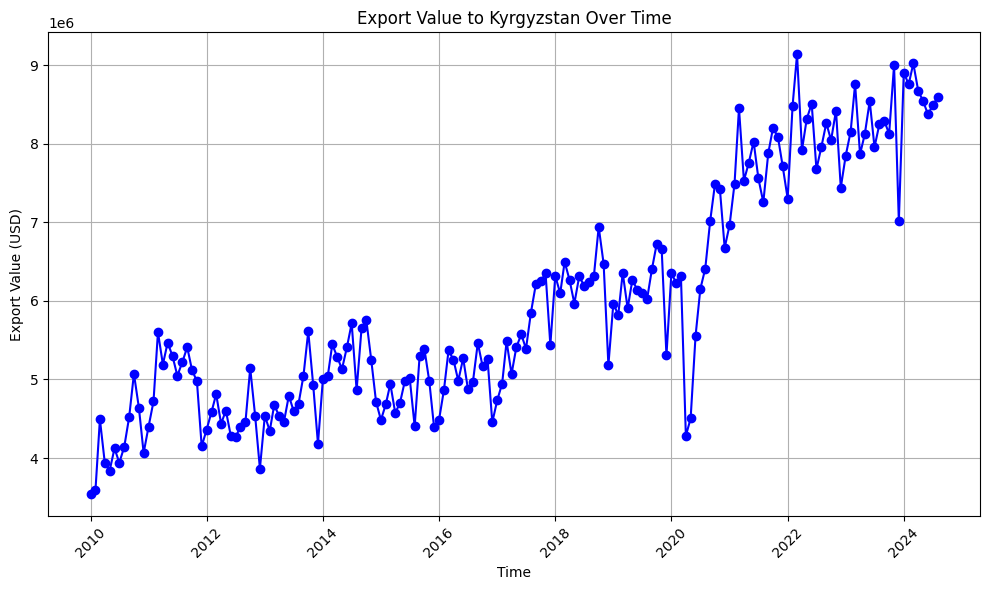

/tmp/ipykernel_67483/1008074454.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Before Feb 2022', 'After Feb 2022'], y=[avg_before, avg_after], palette='viridis')


Average Export Value Before February 2022: 5483221.38 USD
Average Export Value After February 2022: 8299269.27 USD
t-statistic: -22.40, p-value: 0.0000
The change in export value is statistically significant.


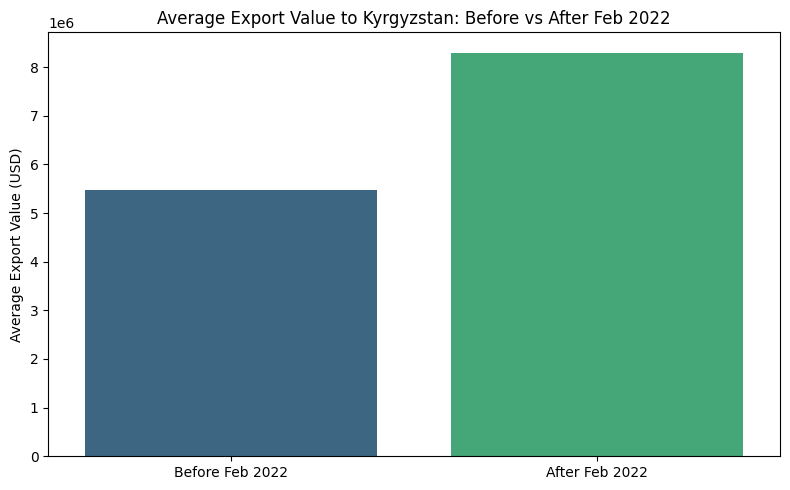

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file to examine its structure
file_path = 'data/import_volume_data.csv'
data = pd.read_csv(file_path, delimiter=';')

# Filter for export value in US Dollars
data_filtered = data[data['value_variable_label'].str.contains('Exports: Value \(US-Dollar\)', case=False, na=False)]

# Create a datetime column from year and month
data_filtered['datetime'] = pd.to_datetime(
    data_filtered['time'].astype(str) + ' ' + data_filtered['1_variable_attribute_label'],
    format='%Y %B',
    errors='coerce'
)

# Drop rows with NaT in 'datetime' after conversion to avoid issues
data_filtered = data_filtered.dropna(subset=['datetime'])

# Convert value to numeric
data_filtered['value'] = pd.to_numeric(data_filtered['value'], errors='coerce')

# Extract data for Kyrgyzstan (since 05/1992)
kyrgyzstan_data = data_filtered[data_filtered['3_variable_attribute_label'].str.lower() == 'poland'.lower()]

# Sort Kyrgyzstan data by year and month
kyrgyzstan_data = kyrgyzstan_data.sort_values(by='datetime')


# -----------------------------------------------------------------------------
# Analysis and Visualization of Kyrgyzstan Data
# -----------------------------------------------------------------------------

# Load the saved Kyrgyzstan data and ensure it is sorted by datetime
kyrgyzstan_data['datetime'] = pd.to_datetime(kyrgyzstan_data['datetime'], errors='coerce')
kyrgyzstan_data = kyrgyzstan_data.sort_values(by='datetime')

# Plot the export value over time
plt.figure(figsize=(10, 6))
plt.plot(kyrgyzstan_data['datetime'], kyrgyzstan_data['value'], marker='o', linestyle='-', color='b')
plt.title('Export Value to Kyrgyzstan Over Time')
plt.xlabel('Time')
plt.ylabel('Export Value (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistical Analysis: Before and After February 2022
before_feb_2022 = kyrgyzstan_data[kyrgyzstan_data['datetime'] < '2022-03-01']
after_feb_2022 = kyrgyzstan_data[kyrgyzstan_data['datetime'] >= '2022-03-01']

# Calculate average export value before and after February 2022
avg_before = before_feb_2022['value'].mean()
avg_after = after_feb_2022['value'].mean()

print(f"Average Export Value Before February 2022: {avg_before:.2f} USD")
print(f"Average Export Value After February 2022: {avg_after:.2f} USD")

# Perform a t-test to check for statistically significant changes
if len(before_feb_2022) > 1 and len(after_feb_2022) > 1:
    t_stat, p_value = ttest_ind(before_feb_2022['value'], after_feb_2022['value'], equal_var=False, nan_policy='omit')
    print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("The change in export value is statistically significant.")
    else:
        print("The change in export value is not statistically significant.")
else:
    print("Not enough data points for a reliable t-test.")

# Plot comparison of average export values before and after February 2022
plt.figure(figsize=(8, 5))
sns.barplot(x=['Before Feb 2022', 'After Feb 2022'], y=[avg_before, avg_after], palette='viridis')
plt.title('Average Export Value to Kyrgyzstan: Before vs After Feb 2022')
plt.ylabel('Average Export Value (USD)')
plt.tight_layout()
plt.show()


Country: Turkey, Change Dates: [Timestamp('2022-02-01 00:00:00')]


/tmp/ipykernel_67483/3183348018.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['datetime'] = pd.to_datetime(


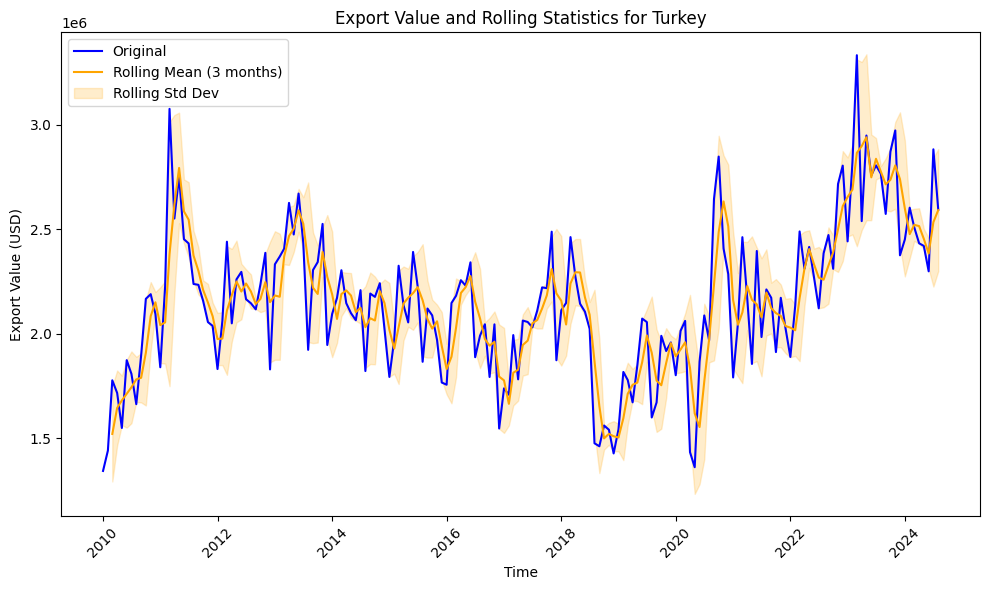

Country: Armenia (since 05/1992), Change Dates: [Timestamp('2022-02-01 00:00:00')]


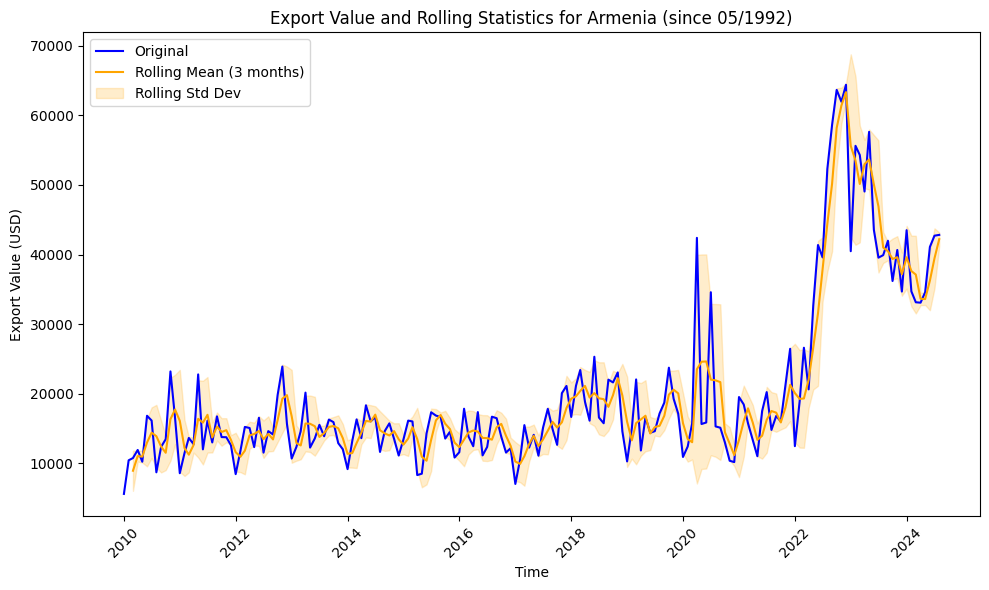

Country: Kyrgyzstan (since 05/1992), Change Dates: [Timestamp('2022-07-01 00:00:00')]


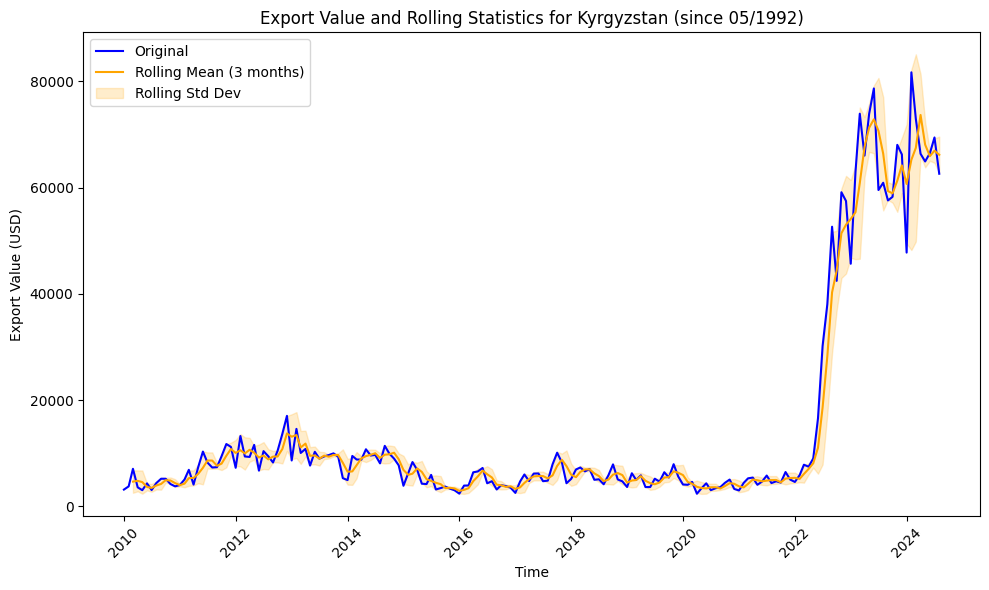

Country: Stores and provisions, Change Dates: [Timestamp('2022-02-01 00:00:00')]


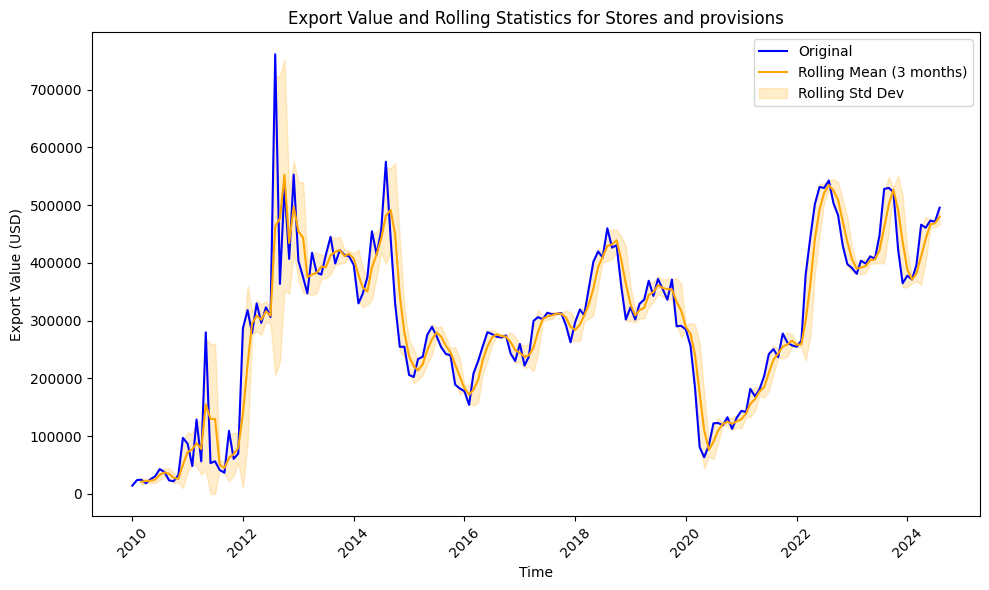

Country: Georgia (since 05/1992), Change Dates: [Timestamp('2022-07-01 00:00:00')]


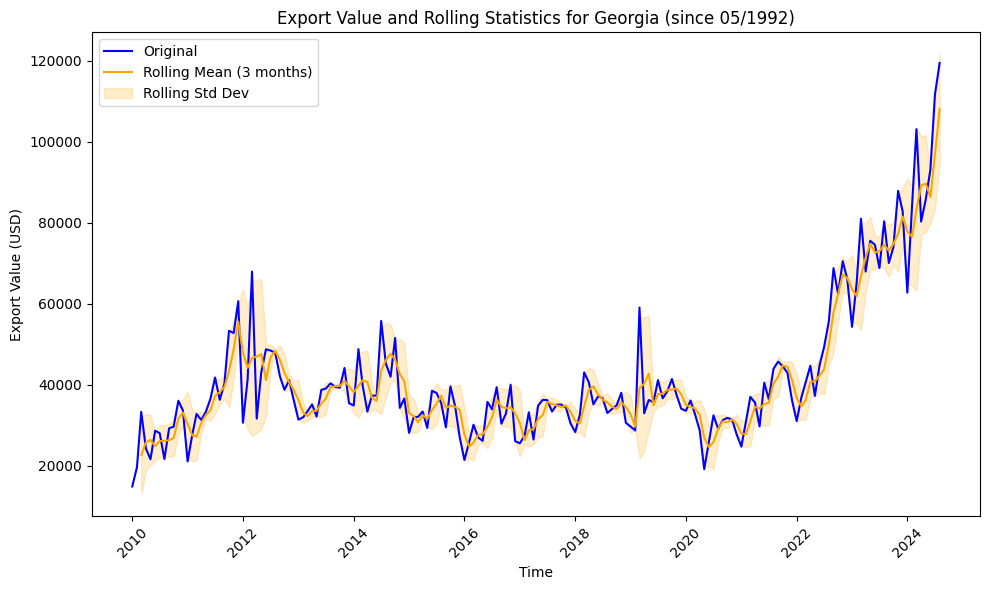

Country: United States, Change Dates: [Timestamp('2022-02-01 00:00:00')]


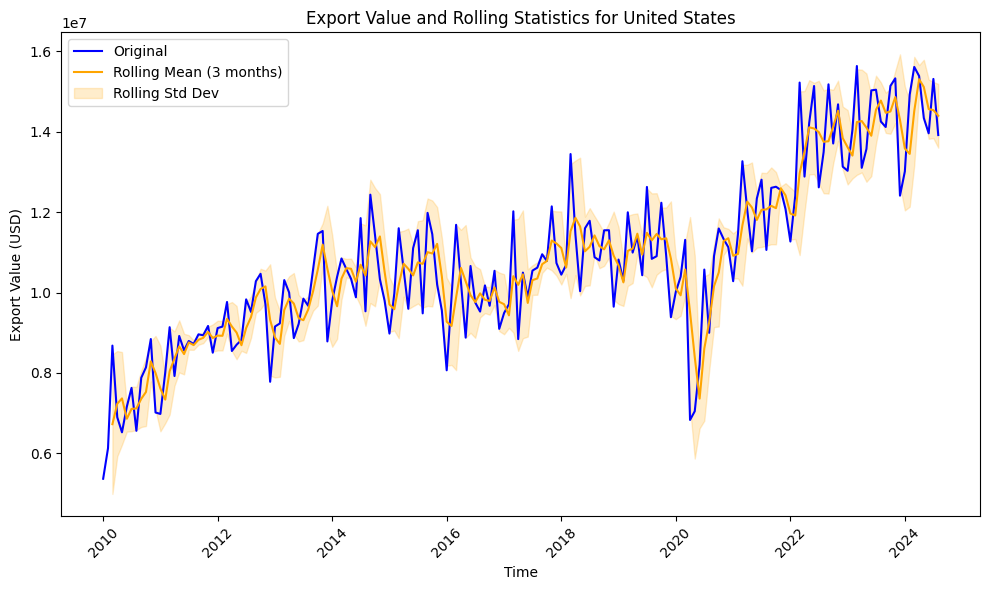

Country: Russian Federation (since 05/1992), Change Dates: [Timestamp('2022-02-01 00:00:00')]


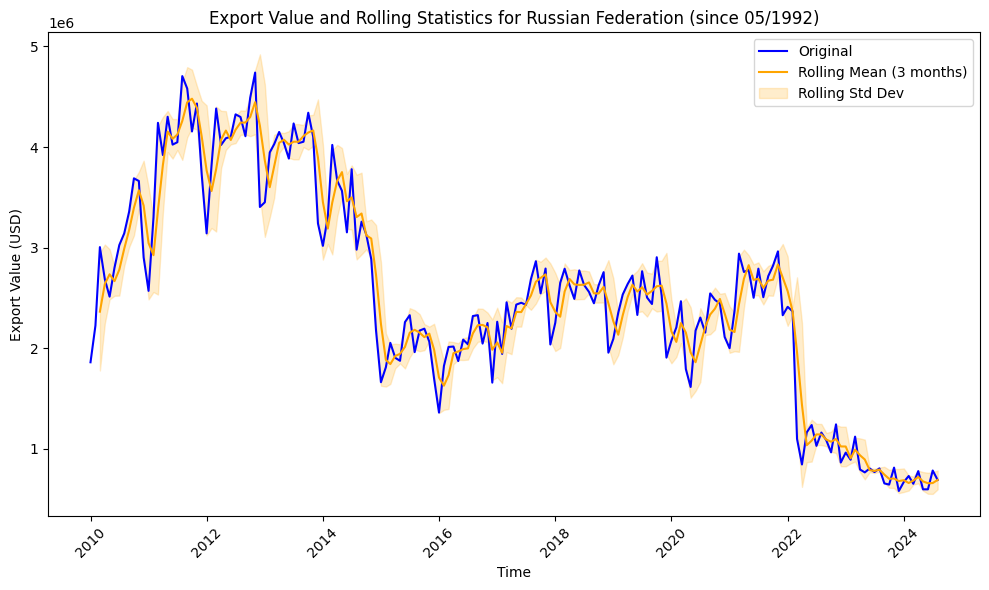

Country: Montenegro (since 06/2005), Change Dates: [Timestamp('2022-12-01 00:00:00')]


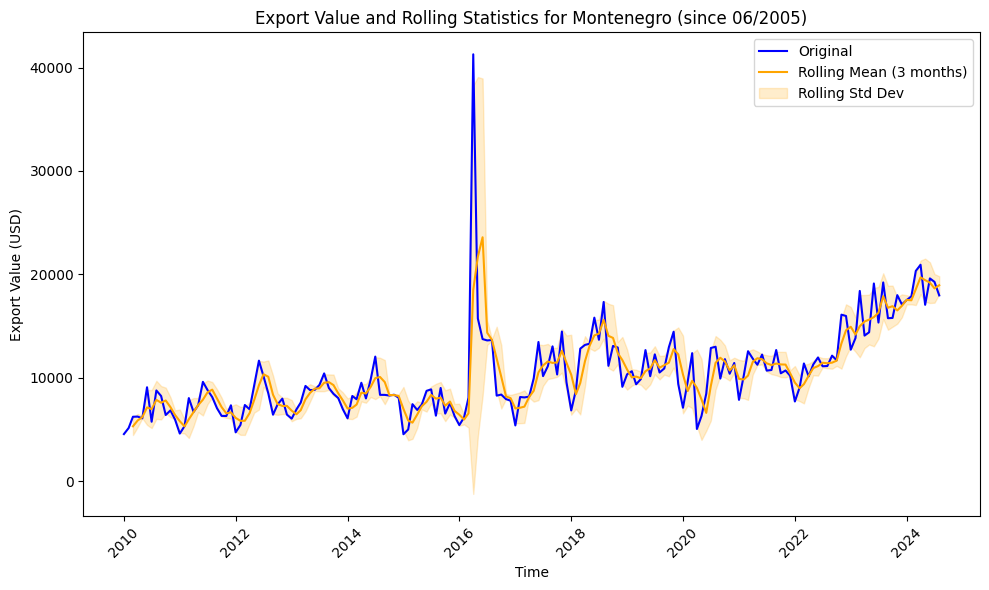

Country: Croatia (since 05/1992), Change Dates: [Timestamp('2022-02-01 00:00:00')]


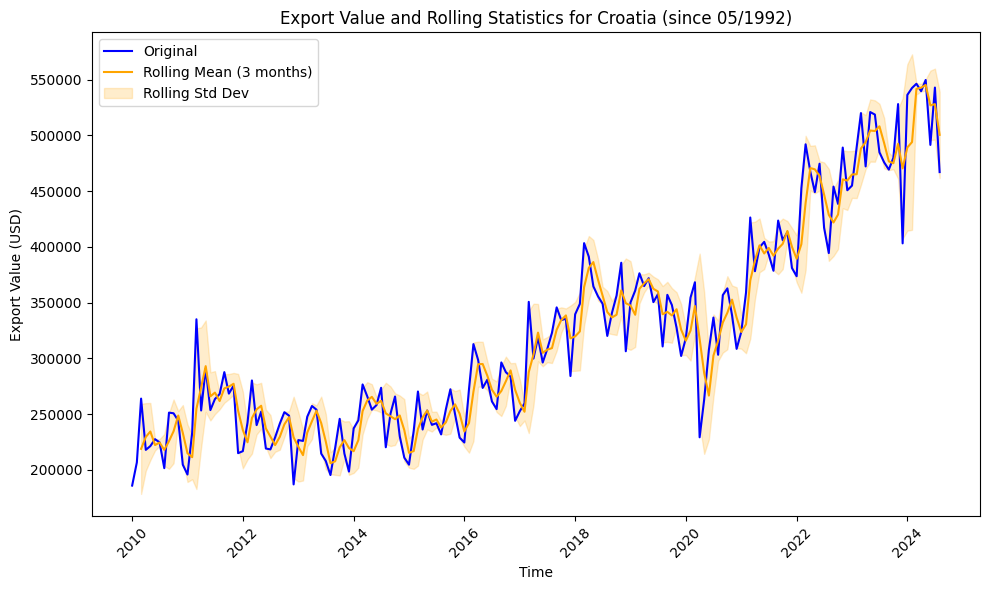

Country: Kazakhstan (since 05/1992), Change Dates: [Timestamp('2022-07-01 00:00:00')]


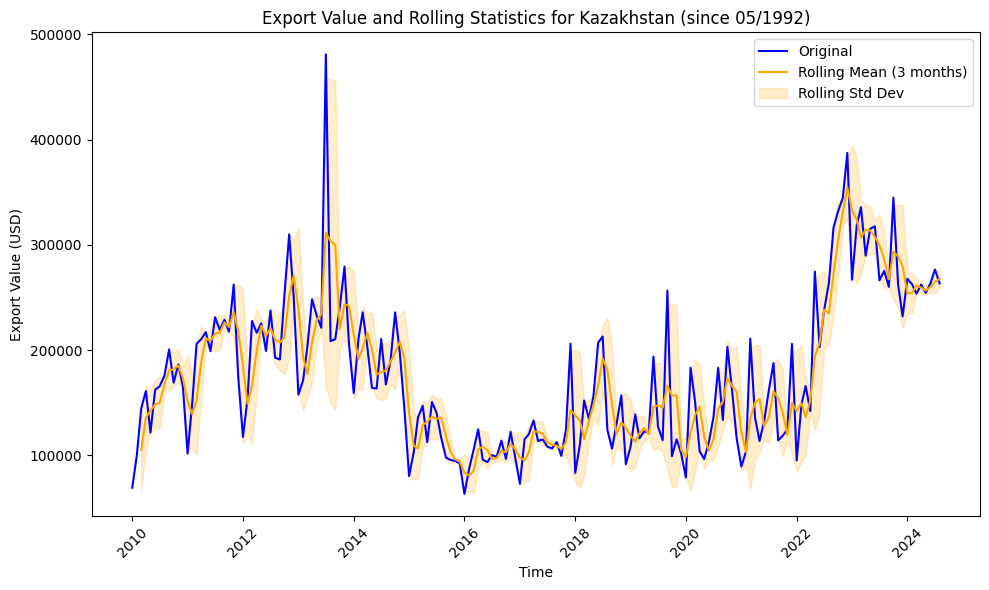

Country: Cyprus, Change Dates: [Timestamp('2022-12-01 00:00:00')]


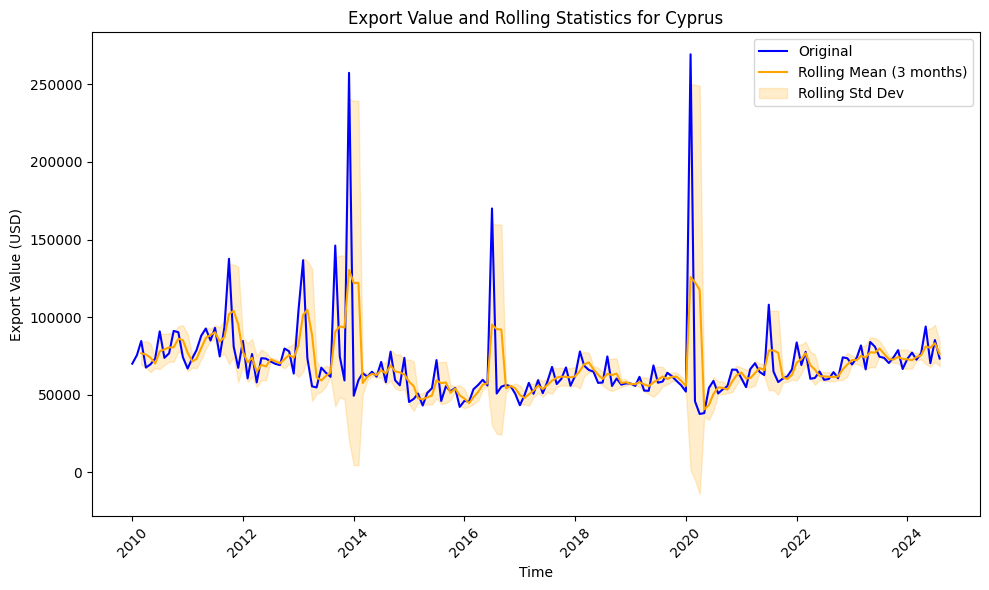

Country: Morocco, Change Dates: [Timestamp('2022-02-01 00:00:00')]


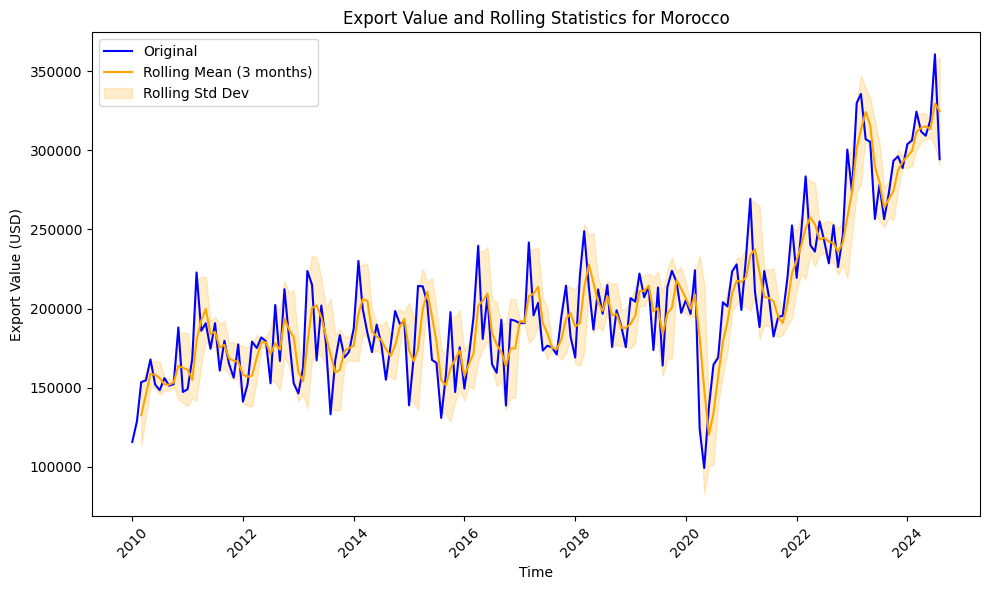

Country: Canada, Change Dates: [Timestamp('2022-02-01 00:00:00')]


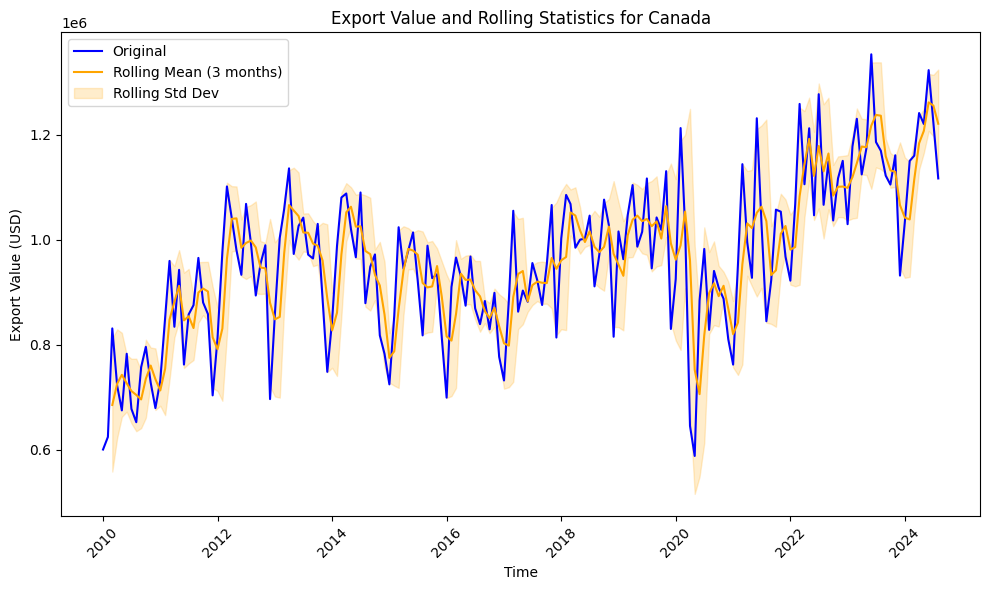

Country: Sri Lanka, Change Dates: [Timestamp('2022-02-01 00:00:00')]


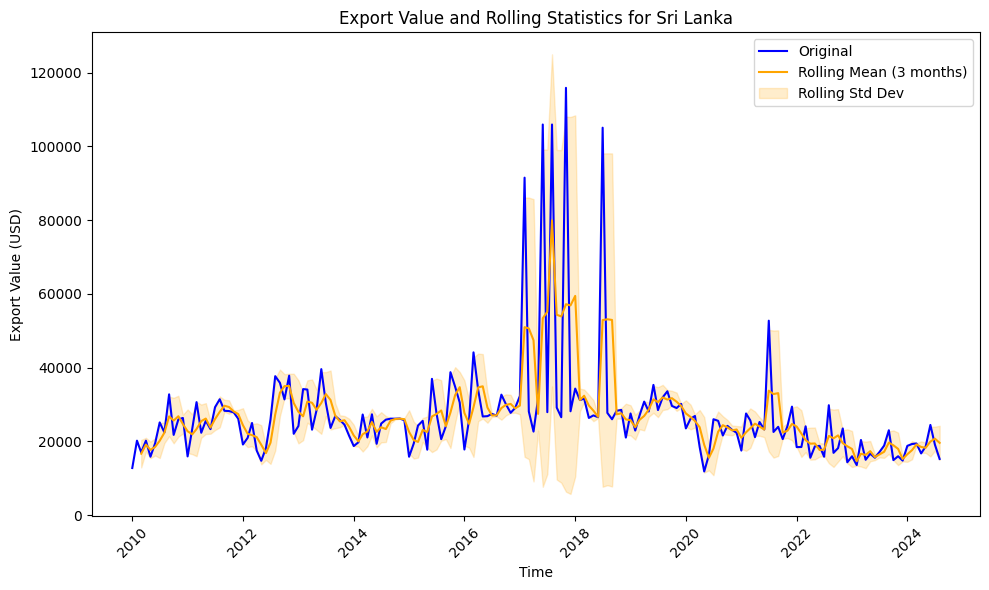

In [46]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import ruptures as rpt

# Load the CSV file to examine its structure
file_path = 'data/import_volume_data.csv'
data = pd.read_csv(file_path, delimiter=';')

# Filter for export value in US Dollars
data_filtered = data[data['value_variable_label'].str.contains('Exports: Value \(US-Dollar\)', case=False, na=False)]

# Create a datetime column from year and month
data_filtered['datetime'] = pd.to_datetime(
    data_filtered['time'].astype(str) + ' ' + data_filtered['1_variable_attribute_label'],
    format='%Y %B',
    errors='coerce'
)

# Drop rows with NaT in 'datetime' after conversion to avoid issues
data_filtered = data_filtered.dropna(subset=['datetime'])

# Convert value to numeric
data_filtered['value'] = pd.to_numeric(data_filtered['value'], errors='coerce')

# Group by country and analyze each country for significant changes using rolling means and change point detection
results = []
for country in data_filtered['3_variable_attribute_label'].unique():
    country_data = data_filtered[data_filtered['3_variable_attribute_label'].str.lower() == country.lower()]
    country_data = country_data.sort_values(by='datetime')

    # Calculate rolling mean and standard deviation (window size = 3 months)
    country_data['rolling_mean'] = country_data['value'].rolling(window=3).mean()
    country_data['rolling_std'] = country_data['value'].rolling(window=3).std()

    # # Plot rolling mean and standard deviation
    # plt.figure(figsize=(10, 6))
    # plt.plot(country_data['datetime'], country_data['value'], label='Original', color='blue')
    # plt.plot(country_data['datetime'], country_data['rolling_mean'], label='Rolling Mean (3 months)', color='orange')
    # plt.fill_between(country_data['datetime'], 
    #                  country_data['rolling_mean'] - country_data['rolling_std'], 
    #                  country_data['rolling_mean'] + country_data['rolling_std'], 
    #                  color='orange', alpha=0.2, label='Rolling Std Dev')
    # plt.title(f'Export Value and Rolling Statistics for {country}')
    # plt.xlabel('Time')
    # plt.ylabel('Export Value (USD)')
    # plt.legend()
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()

    # Change point detection using ruptures library
    signal = country_data['value'].dropna().values
    if len(signal) > 1:
        algo = rpt.Pelt(model="rbf").fit(signal)
        change_points = algo.predict(pen=10)
        if len(change_points) > 1:  # If any change points are detected
            result = {'Country': country, 'Change Points': change_points[:-1]}
            results.append(result)  # Exclude the last point (end of data)
            change_dates = [country_data.iloc[cp]['datetime'] for cp in result['Change Points'] if country_data.iloc[cp]['datetime'].year == 2022]
            if change_dates:
                print(f"Country: {country}, Change Dates: {change_dates}")
                    # # Plot rolling mean and standard deviation
                plt.figure(figsize=(10, 6))
                plt.plot(country_data['datetime'], country_data['value'], label='Original', color='blue')
                plt.plot(country_data['datetime'], country_data['rolling_mean'], label='Rolling Mean (3 months)', color='orange')
                plt.fill_between(country_data['datetime'], 
                                 country_data['rolling_mean'] - country_data['rolling_std'], 
                                 country_data['rolling_mean'] + country_data['rolling_std'], 
                                 color='orange', alpha=0.2, label='Rolling Std Dev')
                plt.title(f'Export Value and Rolling Statistics for {country}')
                plt.xlabel('Time')
                plt.ylabel('Export Value (USD)')
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

In [47]:
# Display the countries with detected change points in 2022
print("Countries with Detected Change Points in 2022:")
for result in results:
    country = result['Country']
    country_data = data_filtered[data_filtered['3_variable_attribute_label'].str.lower() == country.lower()]
    country_data = country_data.sort_values(by='datetime')
    change_dates = [country_data.iloc[cp]['datetime'] for cp in result['Change Points'] if country_data.iloc[cp]['datetime'].year == 2022]
    if change_dates:
        print(f"Country: {country}, Change Dates: {change_dates}")

Countries with Detected Change Points in 2022:
Country: Turkey, Change Dates: [Timestamp('2022-02-01 00:00:00')]
Country: Armenia (since 05/1992), Change Dates: [Timestamp('2022-02-01 00:00:00')]
Country: Kyrgyzstan (since 05/1992), Change Dates: [Timestamp('2022-07-01 00:00:00')]
Country: Stores and provisions, Change Dates: [Timestamp('2022-02-01 00:00:00')]
Country: Georgia (since 05/1992), Change Dates: [Timestamp('2022-07-01 00:00:00')]
Country: United States, Change Dates: [Timestamp('2022-02-01 00:00:00')]
Country: Russian Federation (since 05/1992), Change Dates: [Timestamp('2022-02-01 00:00:00')]
Country: Montenegro (since 06/2005), Change Dates: [Timestamp('2022-12-01 00:00:00')]
Country: Croatia (since 05/1992), Change Dates: [Timestamp('2022-02-01 00:00:00')]
Country: Kazakhstan (since 05/1992), Change Dates: [Timestamp('2022-07-01 00:00:00')]
Country: Cyprus, Change Dates: [Timestamp('2022-12-01 00:00:00')]
Country: Morocco, Change Dates: [Timestamp('2022-02-01 00:00:00')]